# Question 1: [Index] S&P 500 Stocks Added to the Index

Which year had the highest number of additions?

Using the list of S&P 500 companies from Wikipedia's [S&P 500 companies page][wiki-page], download the data including the year each company was added to the index.

- Create a DataFrame with company tickers, names, and the year they were added.
- Extract the year from the addition date and calculate the number of stocks added each year.
- Which year had the highest number of additions (1957 doesn't count, as it was the year when the S&P 500 index was founded)? Write down this year as your answer (the most recent one, if you have several records).

Context:

>" Following the announcement, all four new entrants saw their stock prices rise in extended trading on Friday" - recent examples of S&P 500 additions include DASH, WSM, EXE, TKO in 2025 ([Nasdaq article][nasdaq-article]).

Additional: How many current S&P 500 stocks have been in the index for more than 20 years? When stocks are added to the S&P 500, they usually experience a price bump as investors and index funds buy shares following the announcement.

[wiki-page]: https://en.wikipedia.org/wiki/List_of_S%26P_500_companies
[nasdaq-article]: https://www.nasdaq.com/articles/sp-500-reshuffle-dash-tko-expe-wsm-join-worth-buying

In [1]:
from bs4 import BeautifulSoup
from datetime import date
from polars import col as c
import polars as pl
import requests as r

resp = r.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
doc = BeautifulSoup(resp.content, 'html.parser')
table = doc.find_all(id='constituents')[0]
headers = [str(h.get_text().strip()).lower() for h in table.find_all(name='th')]
rows = [
    [str(cell.get_text().strip()) for cell in row.find_all(name='td')]
    for row in table.find_all(name='tr')[1:]   # for some strange reasons, header row (tr > th) is the first row in  <tbody>
]
df = pl.DataFrame([dict(zip(headers, row)) for row in rows]).with_columns(
    year=c("date added").str.strptime(pl.Date, "%Y-%m-%d").dt.year()
).select('symbol', 'security', 'year')
df.head()

symbol,security,year
str,str,i32
"""MMM""","""3M""",1957
"""AOS""","""A. O. Smith""",2017
"""ABT""","""Abbott Laboratories""",1957
"""ABBV""","""AbbVie""",2012
"""ACN""","""Accenture""",2011


In [2]:
df.group_by('year').agg(
    num_additions=pl.first().filter(c('year') != 1957).count()
).sort(['num_additions', 'year'], descending=True).head()

year,num_additions
i32,u32
2017,23
2016,23
2019,22
2008,17
2024,16


For simplicity, only the (extracted) year component used to determine whether the company is on S&P 500 for more than 20 years.

In [3]:
df.filter(c('year') + 20 < date.today().year).select(pl.first().count()).item(0, 0)

219

# Question 2. [Macro] Indexes YTD (as of 1 May 2025)

How many indexes (out of 10) have better year-to-date returns than the US (S&P 500) as of May 1, 2025?

Using Yahoo Finance World Indices data, compare the year-to-date (YTD) performance (1 January-1 May 2025) of major stock market indexes for the following countries:

- United States - S&P 500 (^GSPC)
- China - Shanghai Composite (000001.SS)
- Hong Kong - HANG SENG INDEX (^HSI)
- Australia - S&P/ASX 200 (^AXJO)
- India - Nifty 50 (^NSEI)
- Canada - S&P/TSX Composite (^GSPTSE)
- Germany - DAX (^GDAXI)
- United Kingdom - FTSE 100 (^FTSE)
- Japan - Nikkei 225 (^N225)
- Mexico - IPC Mexico (^MXX)
- Brazil - Ibovespa (^BVSP)

Hint: use `start_date='2025-01-01'` and `end_date='2025-05-01'` when downloading daily data in yfinance

Context:

> [Global Valuations: Who's Cheap][global-valuations], Who's Not? article suggests "Other regions may be growing faster than the US and you need to diversify."

Reference: Yahoo Finance World Indices - https://finance.yahoo.com/world-indices/

Additional: How many of these indexes have better returns than the S&P 500 over 3, 5, and 10 year periods? Do you see the same trend? Note: For simplicity, ignore currency conversion effects.)

[global-valuations]: https://simplywall.st/article/beyond-the-us-global-markets-after-yet-another-tariff-update

In [4]:
import yfinance as yf
from pathlib import Path

def load_index(index: str, start='2025-01-01', end='2025-05-01') -> pl.DataFrame:
    fname = Path.cwd() / f"{index[1:] if index.startswith('^') else index}-{start}-{end}.csv".lower()
    
    if fname.exists():
        df = pl.read_csv(fname).with_columns(Date=c('Date').str.slice(0, 10).str.strptime(pl.Date, '%Y-%m-%d'))
    else:
        df = pl.DataFrame(yf.Ticker(index).history(start=start, end=end).reset_index())
        df.write_csv(fname)   # cache the data to prevent API throttling problems during experimentations
    
    return df.sort('Date', descending=False)

def calculate_ytd_performance(df: pl.DataFrame) -> float:
    return df['Close'].item(-1) / df['Close'].item(0) - 1

Let's get the YTD performances for each index:

In [5]:
indices = {
    'United States - S&P 500': '^GSPC',
    'China - Shanghai Composite': '000001.SS',
    'Hong Kong - HANG SENG INDEX': '^HSI',
    'Australia - S&P/ASX 200': '^AXJO',
    'India - Nifty 50': '^NSEI',
    'Canada - S&P/TSX Composite': '^GSPTSE',
    'Germany - DAX': '^GDAXI',
    'United Kingdom - FTSE 100': '^FTSE',
    'Japan - Nikkei 225': '^N225',
    'Mexico - IPC Mexico': '^MXX',
    'Brazil - Ibovespa': '^BVSP'
}

df = pl.DataFrame([
    {'index': k, 'ytd-perf': calculate_ytd_performance(load_index(v))}
    for k, v in indices.items()
])
df.sort('ytd-perf', descending=True)

index,ytd-perf
str,f64
"""Mexico - IPC Mexico""",0.130494
"""Hong Kong - HANG SENG INDEX""",0.1272
"""Brazil - Ibovespa""",0.124387
"""Germany - DAX""",0.123464
"""United Kingdom - FTSE 100""",0.028426
…,…
"""China - Shanghai Composite""",0.005048
"""Canada - S&P/TSX Composite""",-0.002261
"""Australia - S&P/ASX 200""",-0.009145


Then retrieve S&P 500's performance:

In [6]:
sp = 'United States - S&P 500'
sp_perf = df.filter(c('index') == sp).item(0, 1)
sp_perf

-0.05103300748245043

And finally, count the number of records in the dataframe that's filtered indices with better YTD performance: 

In [7]:
df.filter((c('index') != sp) & (c('ytd-perf') > sp_perf)).select(pl.first().count()).item(0, 0)

9

# Question 3. [Index] S&P 500 Market Corrections Analysis

Calculate the median duration (in days) of significant market corrections in the S&P 500 index.

For this task, define a correction as an event when a stock index goes down by more than 5% from the closest all-time high maximum.

Steps:

1. Download S&P 500 historical data (1950-present) using yfinance
2. Identify all-time high points (where price exceeds all previous prices)
3. For each pair of consecutive all-time highs, find the minimum price in between
4. Calculate drawdown percentages: (high - low) / high × 100
5. Filter for corrections with at least 5% drawdown
6. Calculate the duration in days for each correction period
7. Determine the 25th, 50th (median), and 75th percentiles for correction durations

Context:

> * Investors often wonder about the typical length of market corrections when deciding "when to buy the dip" ([Reddit discussion][reddit]).
> * [A Wealth of Common Sense - How Often Should You Expect a Stock Market Correction?][wealth-cs]

Hint (use this data to compare with your results): Here is the list of top 10 largest corrections by drawdown:

- 2007-10-09 to 2009-03-09: 56.8% drawdown over 517 days
- 2000-03-24 to 2002-10-09: 49.1% drawdown over 929 days
- 1973-01-11 to 1974-10-03: 48.2% drawdown over 630 days
- 1968-11-29 to 1970-05-26: 36.1% drawdown over 543 days
- 2020-02-19 to 2020-03-23: 33.9% drawdown over 33 days
- 1987-08-25 to 1987-12-04: 33.5% drawdown over 101 days
- 1961-12-12 to 1962-06-26: 28.0% drawdown over 196 days
- 1980-11-28 to 1982-08-12: 27.1% drawdown over 622 days
- 2022-01-03 to 2022-10-12: 25.4% drawdown over 282 days
- 1966-02-09 to 1966-10-07: 22.2% drawdown over 240 days

[reddit]: https://www.reddit.com/r/investing/comments/1jrqnte/when_are_you_buying_the_dip/?rdt=64135
[wealth-cs]: https://awealthofcommonsense.com/2022/01/how-often-should-you-expect-a-stock-market-correction/

In [8]:
from datetime import date

df = (
    load_index('^GSPC', start='1950-01-01', end=str(date.today()))
).select('Date', 'Close')
df

Date,Close
date,f64
1950-01-03,16.66
1950-01-04,16.85
1950-01-05,16.93
1950-01-06,16.98
1950-01-09,17.08
…,…
2025-05-27,5921.540039
2025-05-28,5888.549805
2025-05-29,5912.169922


Let's visualize the data:

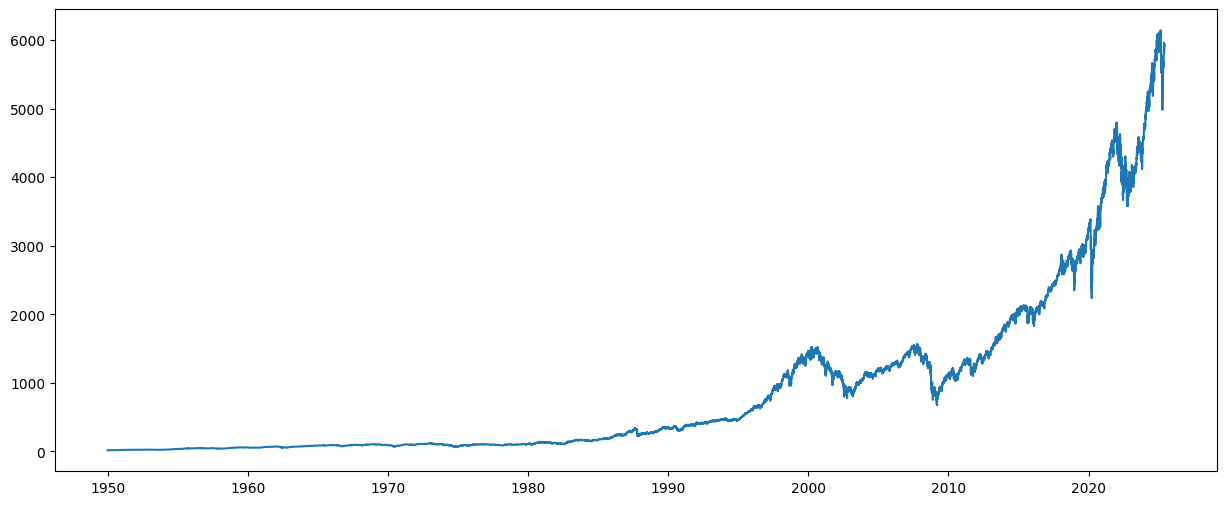

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(df['Date'], df['Close']);

The line seems relatively flat before 1990; this is likely due to the smallish values for that period.
Let's "zoom" in to that period:

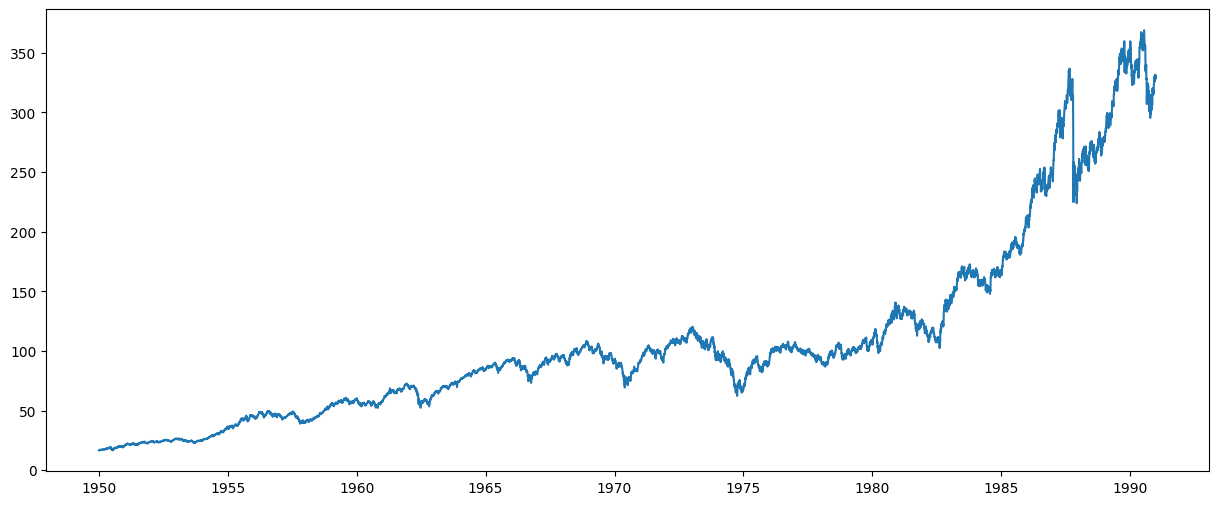

In [10]:
plt.figure(figsize=(15, 6))
pred = c('Date') < date(1990, 12, 31)
plt.plot(df.filter(pred)['Date'], df.filter(pred)['Close']);

As expected, between 1950 and 1990, there too were corrections.

In [11]:
(
    df.with_columns(peak=c('Close').cum_max())
    .group_by('peak')
    .agg(
        low=c('Close').min(),
        start_date=c('Date').first().dt.date(),
        low_date=(c('Date').filter(c('Close').min() == c('Close')).first()).dt.date(),
    )
    .with_columns(
        drawdown=(c('peak') - c('low')) / c('peak') * 100,
        duration=(c('low_date') - c('start_date')).dt.total_days(),
    )
    .filter(c('drawdown') >= 5)
    .sort('drawdown', descending=True)
).select(c('duration').median())

duration
f64
40.5
